# SPICE를 사용한 피치 감지


In [ ]:
# !brew install timidity libsndfile 


==> Downloading https://formulae.brew.sh/api/formula.jws.json
==> Downloading https://formulae.brew.sh/api/cask.jws.json
To reinstall 2.15.0_3, run:
  brew reinstall timidity
To reinstall 1.2.2_1, run:
  brew reinstall libsndfile


In [ ]:
# All the imports to deal with sound data
# !pip3 install pydub librosa music21 tensorflow

In [1]:
!cd /Users/kimberlyjojohirn/Downloads/SeSAC/project/spice


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay
import glob
import os

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import music21
from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
#print("librosa: %s" % librosa.__version__)

tensorflow: 2.19.0


In [ ]:
# 원본파일

In [3]:
import os
from pydub import AudioSegment

data_folder="0_아"
audio_file_list=glob.glob(os.path.join(data_folder, "*.wav"))

EXPECTED_SAMPLE_RATE = 16000

def convert_audio_for_model(data):
    # 리스트가 아니면 리스트로 변환
    if not isinstance(data, list):
        data = [data]

    result = []
    save_dir = "./converted_output"
    os.makedirs(save_dir, exist_ok=True)

    for file in data:
        try:
            # file = file.replace('\\', '/')
            audio = AudioSegment.from_file(file)
            audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)

            # 안전한 파일명 만들기
            base_name = os.path.basename(file)
            safe_name = ''.join(c if c.isalnum() or c in '._-' else '_' for c in base_name)
            output_path = os.path.join(save_dir, 'converted_' + safe_name)

            audio.export(output_path, format="wav")
            result.append(output_path.split('/')[-1])
            
        except Exception as e:
            print(f"[ERROR] 파일 변환 실패: {file} → {e}")

    return result

converted_file_lst=convert_audio_for_model(audio_file_list)
converted_file_lst



['converted_e_1_1.wav',
 'converted_p_1_1.wav',
 'converted_p_2_1.wav',
 'converted_p_1_1.mid_midioutput.wav']

In [4]:
# 일단 한개만...
converted_audio_file = converted_file_lst[0]
dr="converted_output/"
sample_rate, audio_samples = wavfile.read(dr+converted_audio_file, 'rb')

# Show some basic information about the audio.
duration = len(audio_samples)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

# Let's listen to the wav file.
Audio(audio_samples, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 12.03s
Size of the input: 192511


먼저 만들어 놓은 노래의 파형을 살펴보겠습니다.

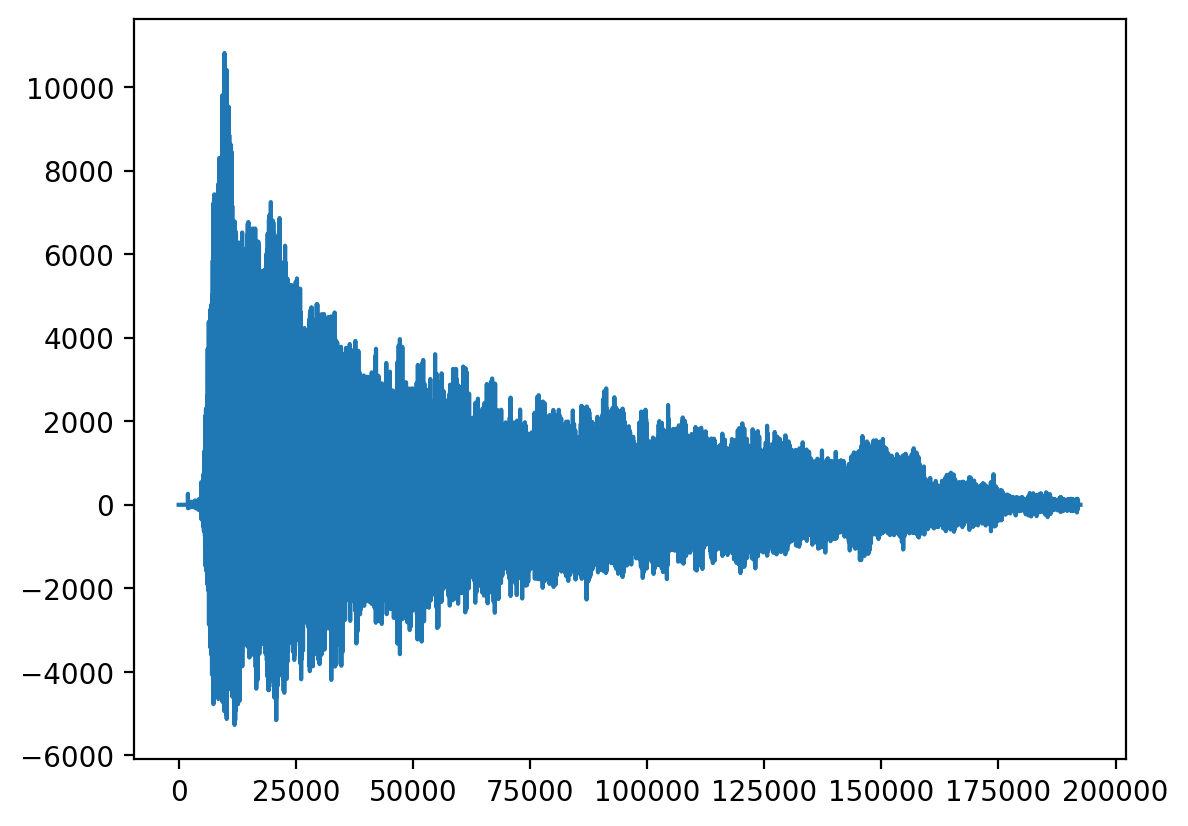

In [5]:
# We can visualize the audio as a waveform.
_ = plt.plot(audio_samples)

보다 유익한 시각화 방법은 시간에 따른 주파수를 보여주는 [스펙트로그램](https://en.wikipedia.org/wiki/Spectrogram)입니다.

여기서는 노래를 더 명확하게 나타내기 위해 로그 주파수 스케일을 사용합니다.


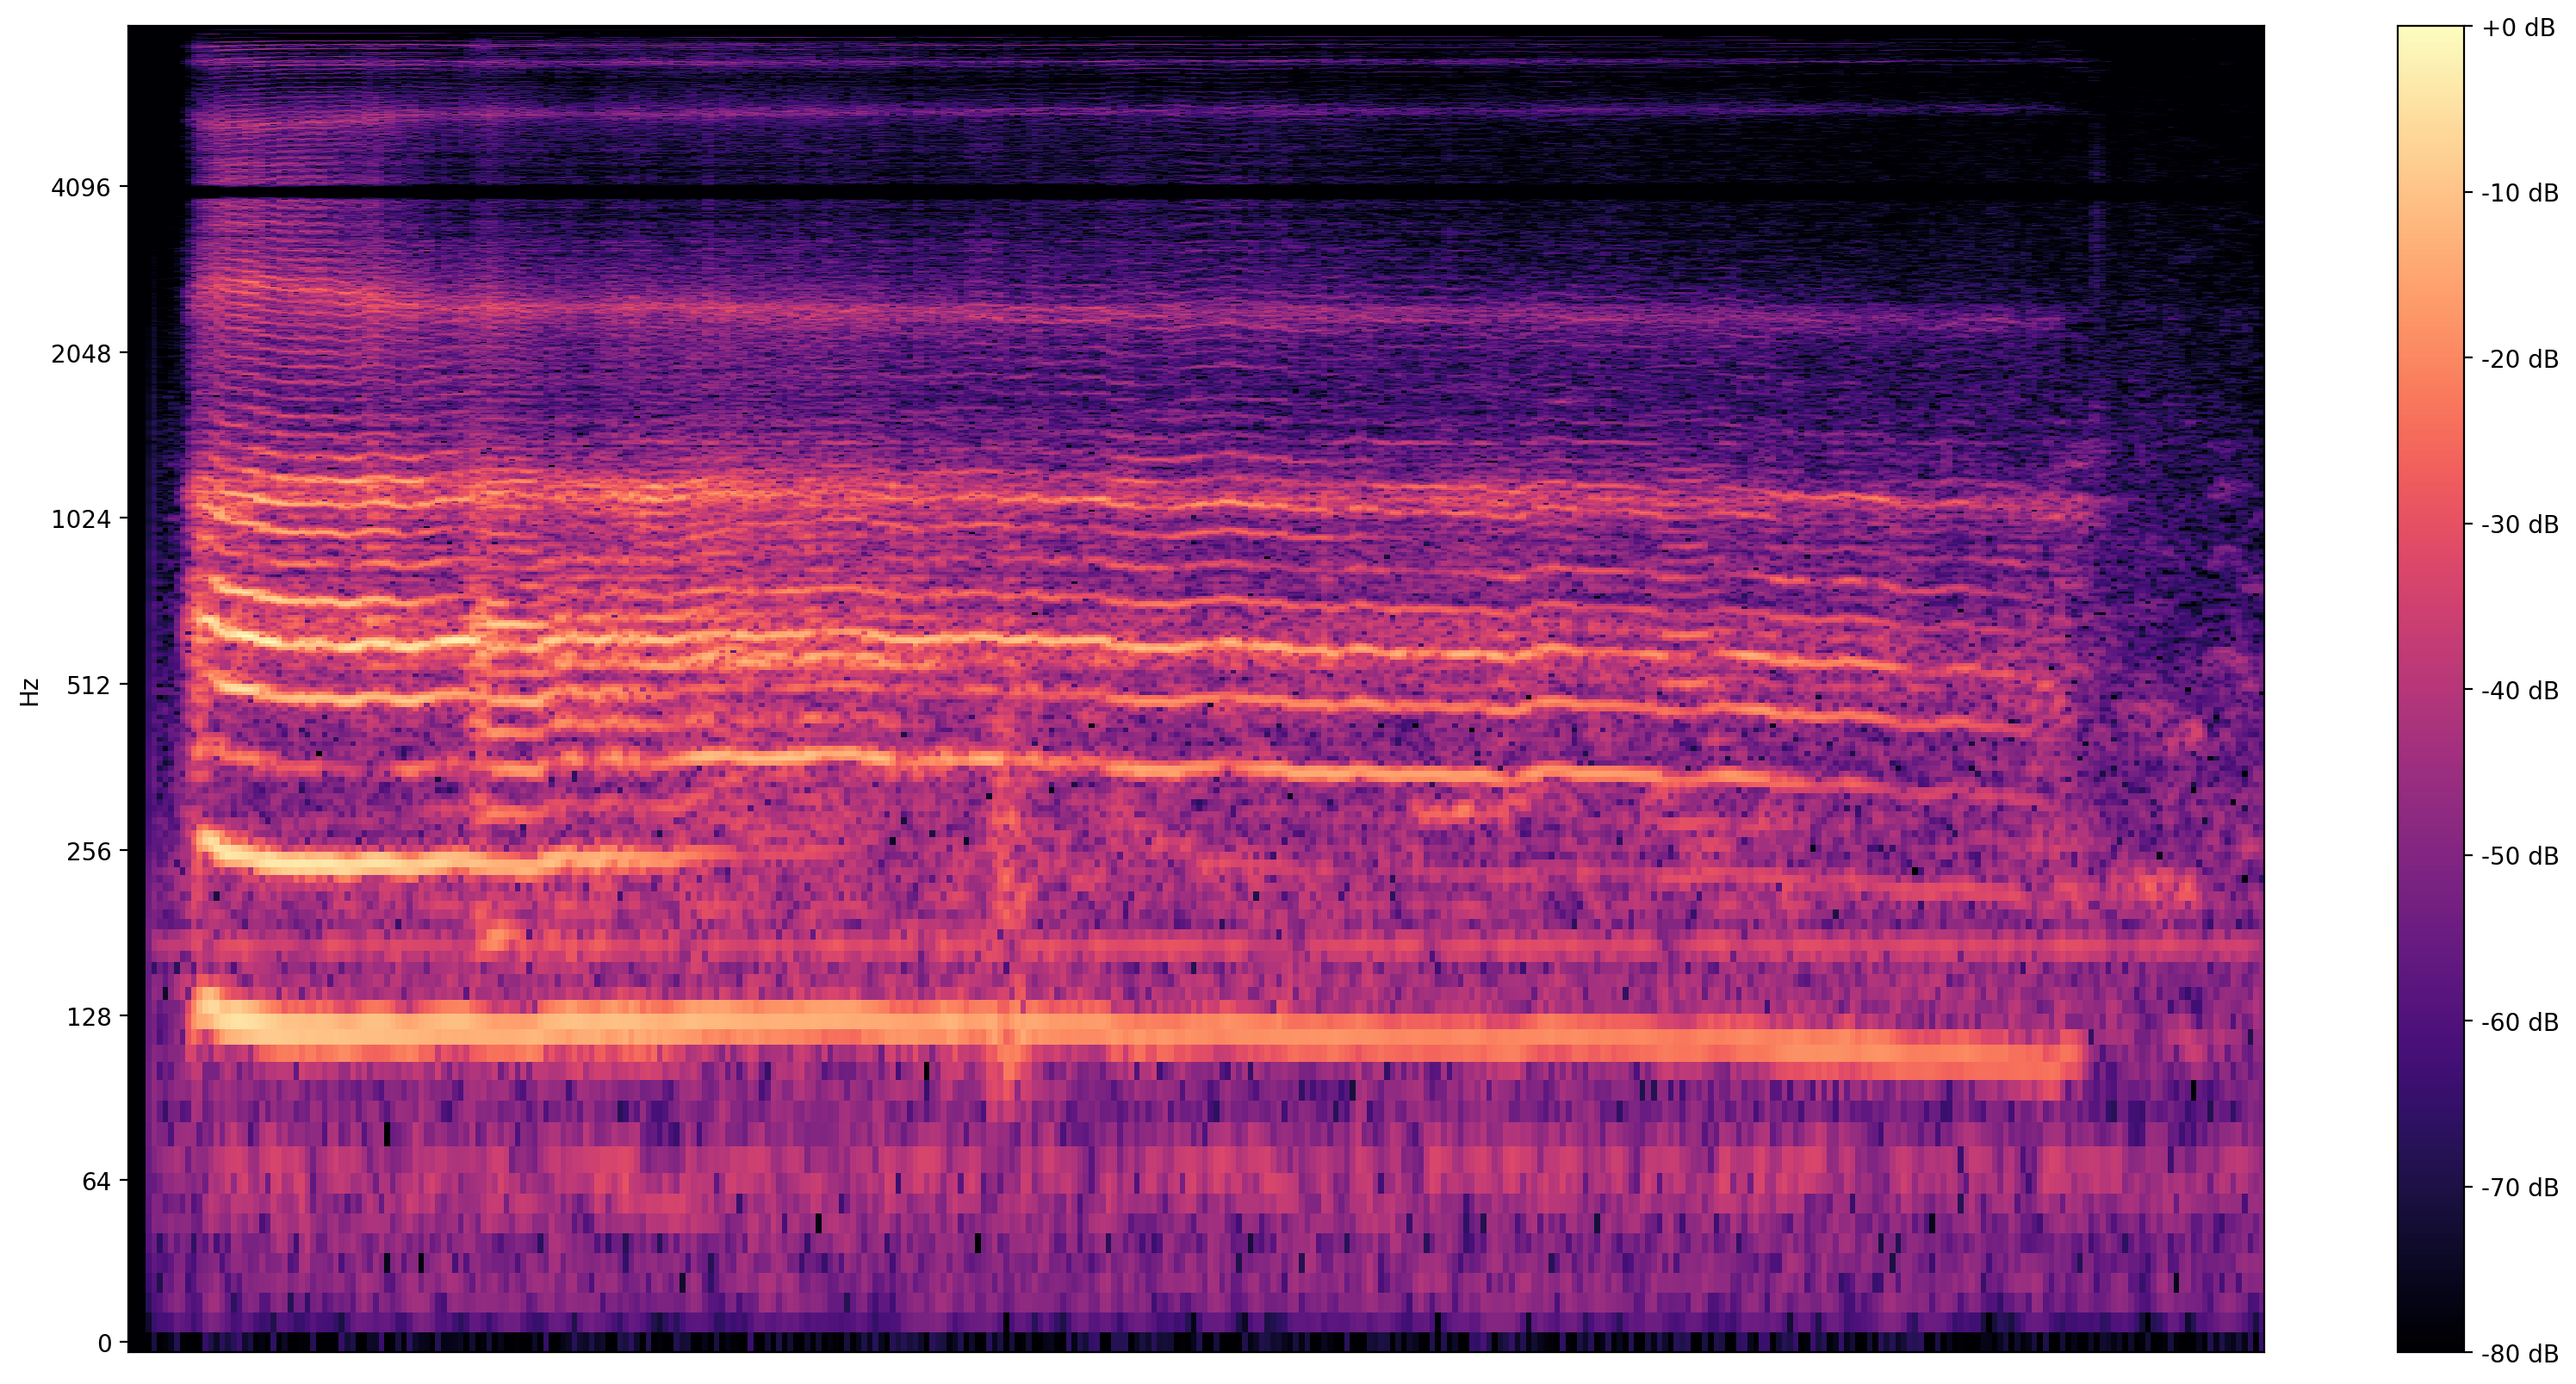

In [ ]:
MAX_ABS_INT16 = 32768.0

def plot_stft(x, sample_rate, show_black_and_white=False):
  x_stft = np.abs(librosa.stft(x, n_fft=2048))
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)
  x_stft_db = librosa.amplitude_to_db(x_stft, ref=np.max)
  if(show_black_and_white):
    librosadisplay.specshow(data=x_stft_db, y_axis='log',
                             sr=sample_rate, cmap='gray_r')
  else:
    librosadisplay.specshow(data=x_stft_db, y_axis='log', sr=sample_rate)

  plt.colorbar(format='%+2.0f dB')

plot_stft(audio_samples / MAX_ABS_INT16 , sample_rate=EXPECTED_SAMPLE_RATE)
plt.show()


│   source ~/opt/anaconda3/etc/profile.d/conda.sh && conda activate SeSAC && pip        │
│   uninstall llvmlite numba -y && conda install llvmlite numba -y    

여기서 마지막 변환이 필요합니다. 오디오 샘플은 int16 형식이며 -1과 1 사이의 부동 소수점으로 정규화해야 합니다.

In [9]:
audio_samples = audio_samples / float(MAX_ABS_INT16)
model = hub.load("https://tfhub.dev/google/spice/2")
# We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]

# 'Uncertainty' basically means the inverse of confidence.
confidence_outputs = 1.0 - uncertainty_outputs

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.plot(pitch_outputs, label='pitch')
plt.plot(confidence_outputs, label='confidence')
plt.legend(loc="lower right")
plt.show()

2025-07-31 20:56:53.536601: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7979688688757498234
2025-07-31 20:56:53.536627: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6620771196806333268
2025-07-31 20:56:53.536633: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: FAILED_PRECONDITION: Attempting to use uninitialized value encoder/dense_1/kernel
	 [[{{node encoder/dense_1/kernel/read}}]]
	 [[stft/frame/Shape/_2]]
2025-07-31 20:56:53.536637: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7237085244283822259
2025-07-31 20:56:53.536641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5013497745593360717
2025-07-31 20:56:53.536644: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 7

FailedPreconditionError: Graph execution error:

Detected at node encoder/dense_1/kernel/read defined at (most recent call last):
  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 397, in dispatch_shell

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 368, in execute_request

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 752, in execute_request

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 455, in do_execute

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 577, in run_cell

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/folders/g9/2k1291915hxbg8w8ghhmgv3h0000gn/T/ipykernel_18666/1293081724.py", line 2, in <module>

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/tensorflow_hub/module_v2.py", line 126, in load

Detected at node encoder/dense_1/kernel/read defined at (most recent call last):
  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 397, in dispatch_shell

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 368, in execute_request

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 752, in execute_request

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 455, in do_execute

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 577, in run_cell

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/folders/g9/2k1291915hxbg8w8ghhmgv3h0000gn/T/ipykernel_18666/1293081724.py", line 2, in <module>

  File "/Users/kimberlyjojohirn/opt/anaconda3/envs/SeSAC/lib/python3.9/site-packages/tensorflow_hub/module_v2.py", line 126, in load

2 root error(s) found.
  (0) FAILED_PRECONDITION:  Attempting to use uninitialized value encoder/dense_1/kernel
	 [[{{node encoder/dense_1/kernel/read}}]]
	 [[stft/frame/Shape/_2]]
  (1) FAILED_PRECONDITION:  Attempting to use uninitialized value encoder/dense_1/kernel
	 [[{{node encoder/dense_1/kernel/read}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_pruned_5619]

신뢰도가 낮은(신뢰도 &lt;0.9) 모든 피치 추정치를 제거하고 나머지 값을 플롯하여 결과를 이해하기 쉽게 만들겠습니다.


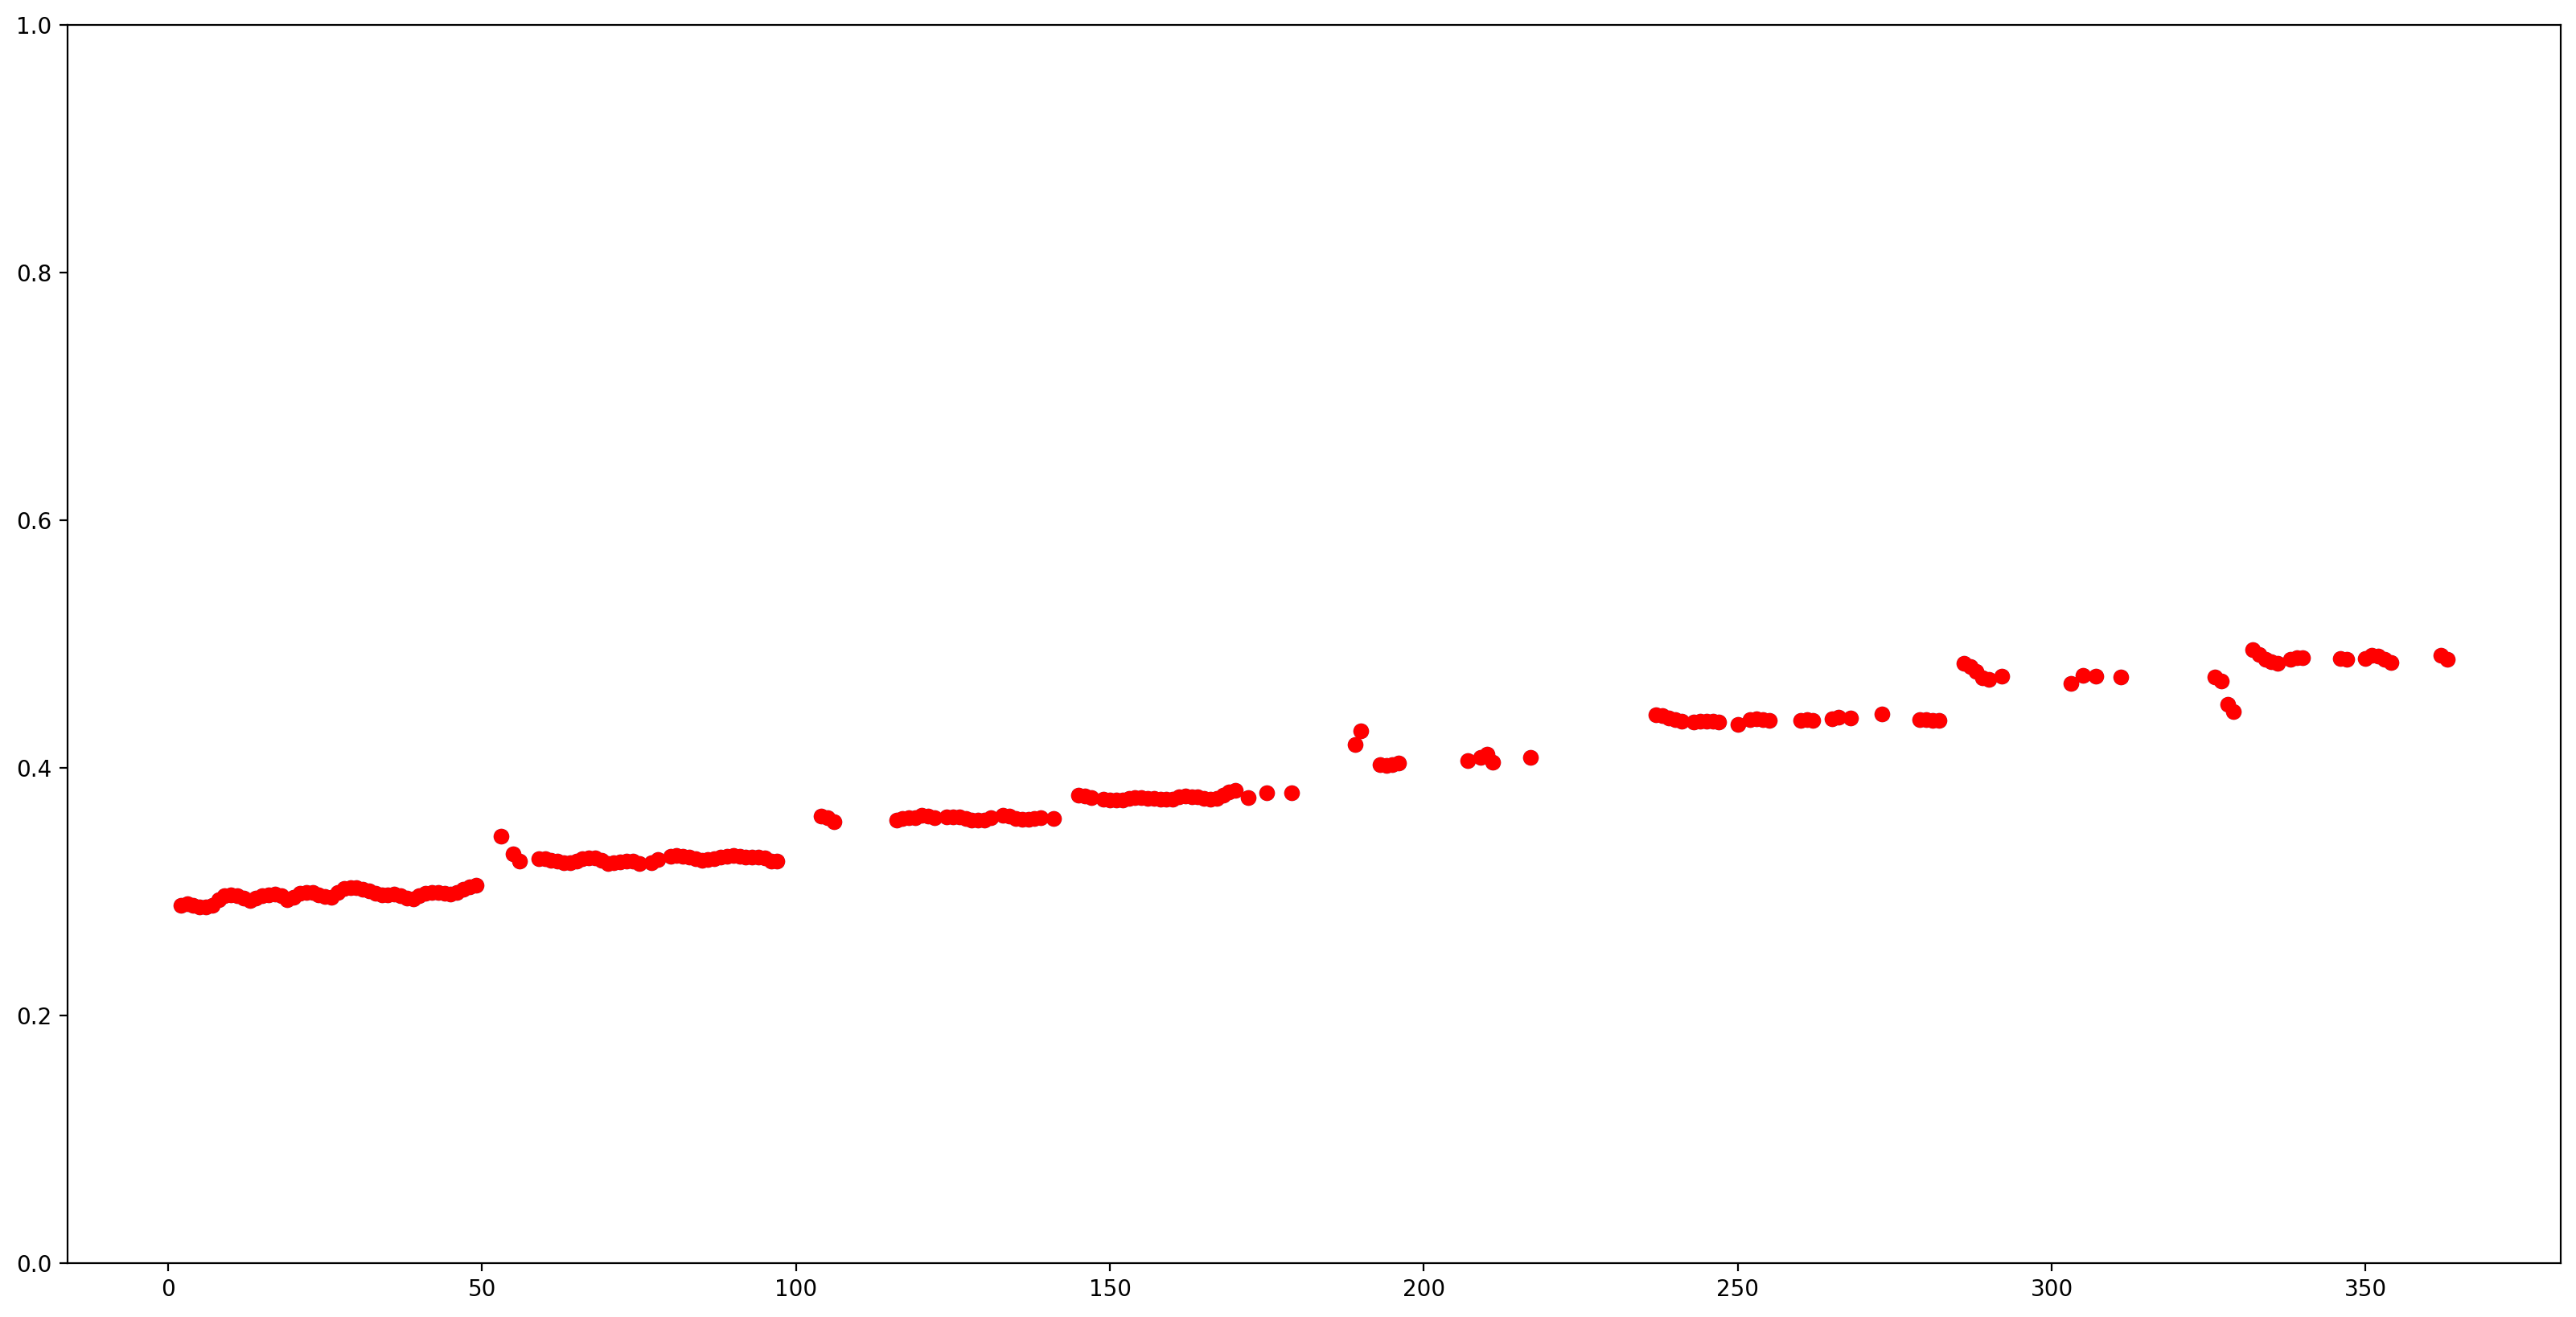

In [ ]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

indices = range(len (pitch_outputs))
confident_pitch_outputs = [ (i,p)
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.9  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_ylim([0, 1])
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

plt.show()

SPICE가 반환하는 피치 값은 0에서 1 사이의 범위에 있습니다. 절대 피치 값(Hz)으로 변환하겠습니다.

In [ ]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)

confident_pitch_values_hz = [ output2hz(p) for p in confident_pitch_outputs_y ]

이제 예측의 성능이 얼마나 좋은지 살펴보겠습니다. 예측된 피치를 원래 스펙트로그램 위에 중첩시킵니다. 피치 예측이 더 잘 보이도록 스펙트로그램을 흑백으로 변경했습니다.

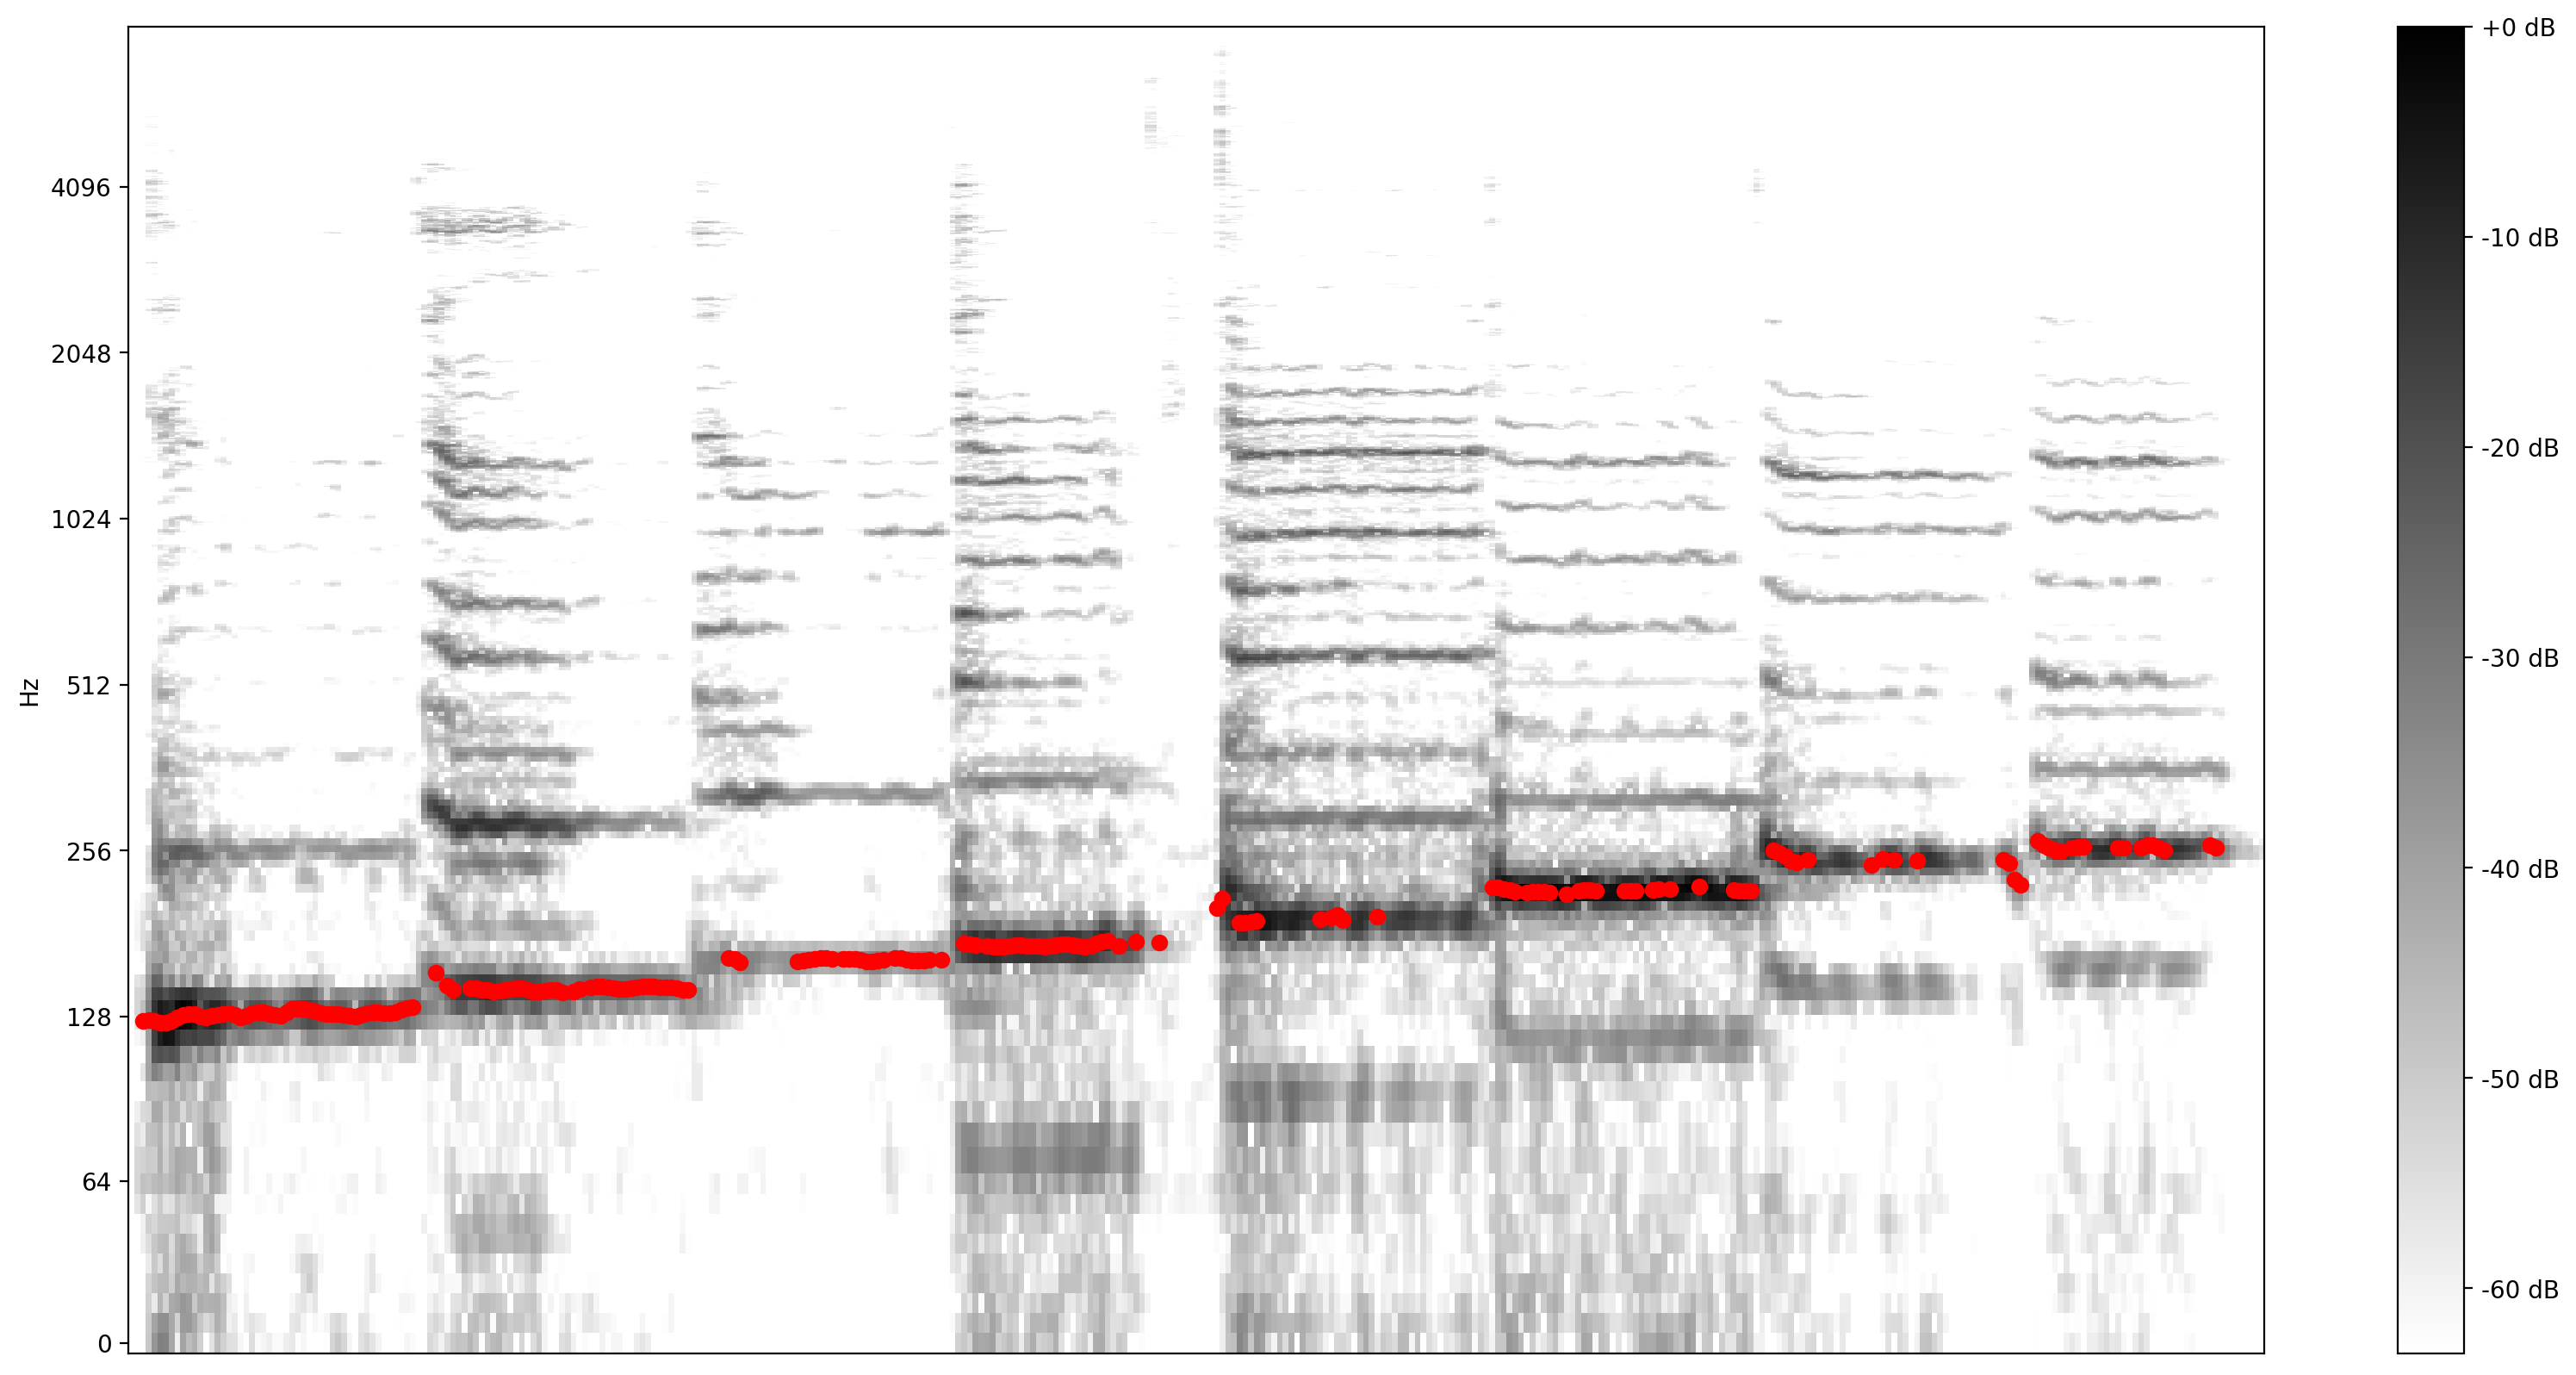

In [ ]:
plot_stft(audio_samples / MAX_ABS_INT16 ,
          sample_rate=EXPECTED_SAMPLE_RATE, show_black_and_white=True)
# Note: conveniently, since the plot is in log scale, the pitch outputs
# also get converted to the log scale automatically by matplotlib.
plt.scatter(confident_pitch_outputs_x, confident_pitch_values_hz, c="r")

plt.show()

# 음표로 변환하기

이제 피치 값을 얻었으므로 이를 음표로 변환하겠습니다! 이 부분은 그 자체로 어렵습니다. 다음 두 가지를 고려해야 합니다.

1. 나머지(노래가 없을 때)
2. 각 음표의 크기(오프셋)

### 1: 노래가 없을 때를 나타내기 위해 출력에 0 추가

In [ ]:
pitch_outputs_and_rests = [
    output2hz(p) if c >= 0.9 else 0
    for i, p, c in zip(indices, pitch_outputs, confidence_outputs)
]

### 2: 음표 오프셋 추가

사람이 자유롭게 노래할 때 멜로디는 음표가 표현할 수 있는 절대 패치 값을 이동시킬 수 있습니다. 따라서 예측을 음표로 변환하려면 이 가능한 오프셋을 수정해야 합니다. 다음 코드가 이 부분을 계산합니다.

In [ ]:
A4 = 440
C0 = A4 * pow(2, -4.75)
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def hz2offset(freq):
  # This measures the quantization error for a single note.
  if freq == 0:  # Rests always have zero error.
    return None
  # Quantized note.
  h = round(12 * math.log2(freq / C0))
  return 12 * math.log2(freq / C0) - h


# The ideal offset is the mean quantization error for all the notes
# (excluding rests):
offsets = [hz2offset(p) for p in pitch_outputs_and_rests if p != 0]
print("offsets: ", offsets)

ideal_offset = statistics.mean(offsets)
print("ideal offset: ", ideal_offset)


offsets:  [0.2851094503825351, 0.3700387640422065, 0.2861658038323682, 0.19609005646164235, 0.17851925210410968, 0.2733467103665532, -0.4475297470266071, -0.24651809109990808, -0.1796539251381688, -0.23059948368612737, -0.37825965149943386, -0.4725081829601976, -0.3457194541269999, -0.2436648090059066, -0.1818925674134988, -0.1348021350676234, -0.24551624699179797, -0.4454884661609313, -0.31267739488426827, -0.12241535707060791, -0.06614292009417966, -0.0670244677240106, -0.1744097505385156, -0.29365363462512306, -0.32520890458170726, -0.05643649800364159, 0.1470506338899895, 0.17167193965372007, 0.16529434667284448, 0.09569907472785388, -0.006323616641203955, -0.11799634112661295, -0.18834910495822044, -0.17934754504506145, -0.17215419157092526, -0.2369545210773225, -0.34594313039129077, -0.39380421205108007, -0.252869369226147, -0.11009248657768467, -0.07118597401920113, -0.08041872872655631, -0.12799410625044771, -0.16227296366040633, -0.05931985421721464, 0.10667988763506742, 0.210

이제 일부 휴리스틱을 사용하여 가장 가능성이 높은 노래의 음표 시퀀스를 시도하고 추정할 수 있습니다. 위에서 계산된 이상적인 오프셋이 하나의 요소이지만, 양자화를 시작하기 위해 속도(8분의 1과 같이 수행되는 예상의 수)와 시간 오프셋도 알아야 합니다. 간단하게 하기 위해 서로 다른 속도와 시간 오프셋을 시도하고 양자화 오류를 측정하여 최종적으로 이 오류를 최소화하는 값을 사용할 것입니다.

In [ ]:
def quantize_predictions(group, ideal_offset):
  # Group values are either 0, or a pitch in Hz.
  non_zero_values = [v for v in group if v != 0]
  zero_values_count = len(group) - len(non_zero_values)

  # Create a rest if 80% is silent, otherwise create a note.
  if zero_values_count > 0.8 * len(group):
    # Interpret as a rest. Count each dropped note as an error, weighted a bit
    # worse than a badly sung note (which would 'cost' 0.5).
    return 0.51 * len(non_zero_values), "Rest"
  else:
    # Interpret as note, estimating as mean of non-rest predictions.
    h = round(
        statistics.mean([
            12 * math.log2(freq / C0) - ideal_offset for freq in non_zero_values
        ]))
    octave = h // 12
    n = h % 12
    note = note_names[n] + str(octave)
    # Quantization error is the total difference from the quantized note.
    error = sum([
        abs(12 * math.log2(freq / C0) - ideal_offset - h)
        for freq in non_zero_values
    ])
    return error, note


def get_quantization_and_error(pitch_outputs_and_rests, predictions_per_eighth,
                               prediction_start_offset, ideal_offset):
  # Apply the start offset - we can just add the offset as rests.
  pitch_outputs_and_rests = [0] * prediction_start_offset + \
                            pitch_outputs_and_rests
  # Collect the predictions for each note (or rest).
  groups = [
      pitch_outputs_and_rests[i:i + predictions_per_eighth]
      for i in range(0, len(pitch_outputs_and_rests), predictions_per_eighth)
  ]

  quantization_error = 0

  notes_and_rests = []
  for group in groups:
    error, note_or_rest = quantize_predictions(group, ideal_offset)
    quantization_error += error
    notes_and_rests.append(note_or_rest)

  return quantization_error, notes_and_rests


best_error = float("inf")
best_notes_and_rests = None
best_predictions_per_note = None

for predictions_per_note in range(20, 65, 1):
  for prediction_start_offset in range(predictions_per_note):

    error, notes_and_rests = get_quantization_and_error(
        pitch_outputs_and_rests, predictions_per_note,
        prediction_start_offset, ideal_offset)

    if error < best_error:
      best_error = error
      best_notes_and_rests = notes_and_rests
      best_predictions_per_note = predictions_per_note

# At this point, best_notes_and_rests contains the best quantization.
# Since we don't need to have rests at the beginning, let's remove these:
while best_notes_and_rests[0] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[1:]
# Also remove silence at the end.
while best_notes_and_rests[-1] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[:-1]

이제 양자화된 음표를 악보로 작성해 보겠습니다!

이 작업을 위해 [music21](http://web.mit.edu/music21/) 및 [Open Sheet Music Display](https://github.com/opensheetmusicdisplay/opensheetmusicdisplay)의 두 가지 라이브러리를 사용합니다.

**참고:** 간단하게 하기 위해 여기서는 모든 음표의 지속 시간이 동일하다고 가정합니다(반음표).

In [ ]:
# Creating the sheet music score.
sc = music21.stream.Score()
# Adjust the speed to match the actual singing.
bpm = 60 * 60 / best_predictions_per_note
print ('bpm: ', bpm)
a = music21.tempo.MetronomeMark(number=bpm)
sc.insert(0,a)

for snote in best_notes_and_rests:
    d = 'half'
    if snote == 'Rest':
      sc.append(music21.note.Rest(type=d))
    else:
      sc.append(music21.note.Note(snote, type=d))

bpm:  78.26086956521739


In [ ]:
#@title [Run this] Helper function to use Open Sheet Music Display (JS code) to show a music score

from IPython.core.display import display, HTML, Javascript
import json, random

def showScore(score):
    xml = open(score.write('musicxml')).read()
    showMusicXML(xml)

def showMusicXML(xml):
    DIV_ID = "OSMD_div"
    display(HTML('<div id="'+DIV_ID+'">loading OpenSheetMusicDisplay</div>'))
    script = """
    var div_id = %%DIV_ID%%;
    function loadOSMD() {
        return new Promise(function(resolve, reject){
            if (window.opensheetmusicdisplay) {
                return resolve(window.opensheetmusicdisplay)
            }
            // OSMD script has a 'define' call which conflicts with requirejs
            var _define = window.define // save the define object
            window.define = undefined // now the loaded script will ignore requirejs
            var s = document.createElement( 'script' );
            s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.7.6/build/opensheetmusicdisplay.min.js" );
            //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
            s.onload=function(){
                window.define = _define
                resolve(opensheetmusicdisplay);
            };
            document.body.appendChild( s ); // browser will try to load the new script tag
        })
    }
    loadOSMD().then((OSMD)=>{
        window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id, {
          drawingParameters: "compacttight"
        });
        openSheetMusicDisplay
            .load(%%data%%)
            .then(
              function() {
                openSheetMusicDisplay.render();
              }
            );
    })
    """.replace('%%DIV_ID%%',DIV_ID).replace('%%data%%',json.dumps(xml))
    display(Javascript(script))
    return

In [ ]:
# rendering the music score
showScore(sc)
print(best_notes_and_rests)

/usr/local/lib/python3.11/dist-packages/music21/musicxml/m21ToXml.py:427: MusicXMLWarning: <music21.stream.Score 0x7cf8d96d7250> is not well-formed; see isWellFormedNotation()
  warnings.warn(f'{sc} is not well-formed; see isWellFormedNotation()',


<IPython.core.display.Javascript object>

['C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4']


음표를 MIDI 파일로 변환하고 들어보겠습니다.

이 파일을 만들기 위해 이전에 만든 스트림을 사용할 수 있습니다.

In [ ]:
# Saving the recognized musical notes as a MIDI file
converted_audio_file_as_midi = converted_audio_file[:-4] + '.mid'
fp = sc.write('midi', fp=converted_audio_file_as_midi)

In [ ]:
# converted_audio_file_as_midi='gumi.mid'

In [ ]:
wav_from_created_midi = converted_audio_file_as_midi.replace(' ', '_') + "_midioutput.wav"
print(wav_from_created_midi)

converted_audio_file.mid_midioutput.wav


colab에서 노래를 들으려면 다시 wav로 변환해야 합니다. Timidity를 사용하면 간단히 해결됩니다.

In [ ]:
!timidity $converted_audio_file_as_midi -Ow -o $wav_from_created_midi

Playing converted_audio_file.mid
MIDI file: converted_audio_file.mid
Format: 1  Tracks: 2  Divisions: 10080
Track name: 
Playing time: ~16 seconds
Notes cut: 0
Notes lost totally: 0


마지막으로, 음표로부터 생성되고 예상된 피치로부터 MIDI를 통해 만들어져 모델에 의해 추론된 오디오를 들어봅니다!


In [ ]:
Audio(wav_from_created_midi)

ValueError: rate must be specified when data is a numpy array or list of audio samples.